<a href="https://colab.research.google.com/github/Aditya2600/Ninjacart-case-study/blob/main/Ninjacart_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**

---



Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.

As a starting point, ninjacart has provided us with a dataset scraped from the web which contains train and test folders, each having 4 sub-folders with images of onions, potatoes, tomatoes and some market scenes. We have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.

In [3]:
import os
import glob
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=ed540722-17cb-43f3-8060-4c03fa2ef6df
To: /content/ninjacart_data.zip
100% 275M/275M [00:01<00:00, 188MB/s]


In [5]:
!unzip -q ninjacart_data.zip

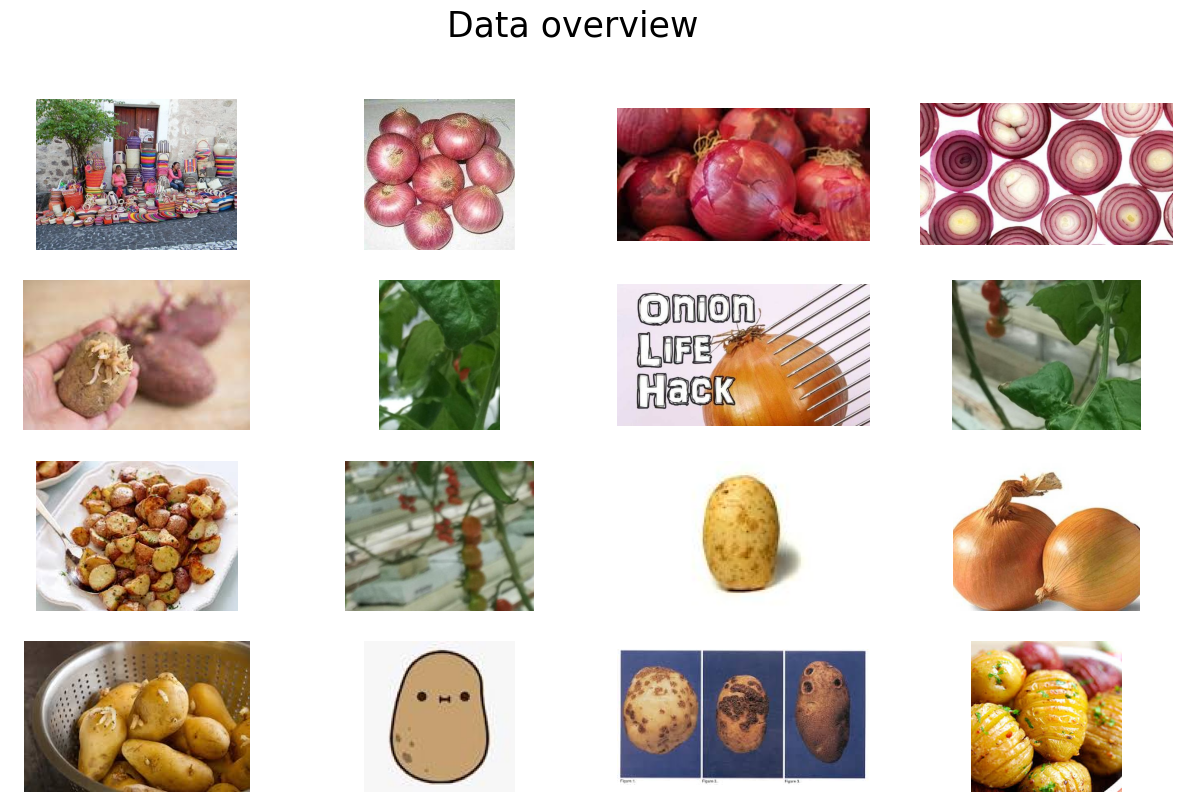

In [6]:
train_folder = '/content/ninjacart_data/train'

images = []
for folder in os.listdir(train_folder):
  for image in os.listdir(os.path.join(train_folder, folder)):
    images.append(os.path.join(train_folder, folder, image))

fig = plt.figure(1, figsize=(15, 9))
fig.suptitle('Data overview', fontsize=25)
plt.axis('off')
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = tf.keras.utils.load_img(random_img)
  plt.subplot(4, 4, n)
  plt.axis('off')
  plt.imshow(imgs)
plt.show()

**Store image arrays and count for each class in data:**

In [7]:
class_dirs = os.listdir("/content/ninjacart_data/train")
image_dict = {}
count_dict = {}

for cls in class_dirs:
    file_paths = glob.glob(f'/content/ninjacart_data/train/{cls}/*')
    count_dict[cls] = len(file_paths)
    image_path = random.choice(file_paths)
    image_dict[cls] = tf.keras.utils.load_img(image_path)

In [8]:
class_dirs_test = os.listdir("/content/ninjacart_data/test")
image_dict_test = {}
count_dict_test = {}

for cls in class_dirs_test:
    file_paths_test = glob.glob(f'/content/ninjacart_data/test/{cls}/*')
    count_dict_test[cls] = len(file_paths_test)
    image_path = random.choice(file_paths_test)
    image_dict_test[cls] = tf.keras.utils.load_img(image_path)

# Image Dimension Analysis:

  Plot a Grid of each training samples from each class to display their dimensions


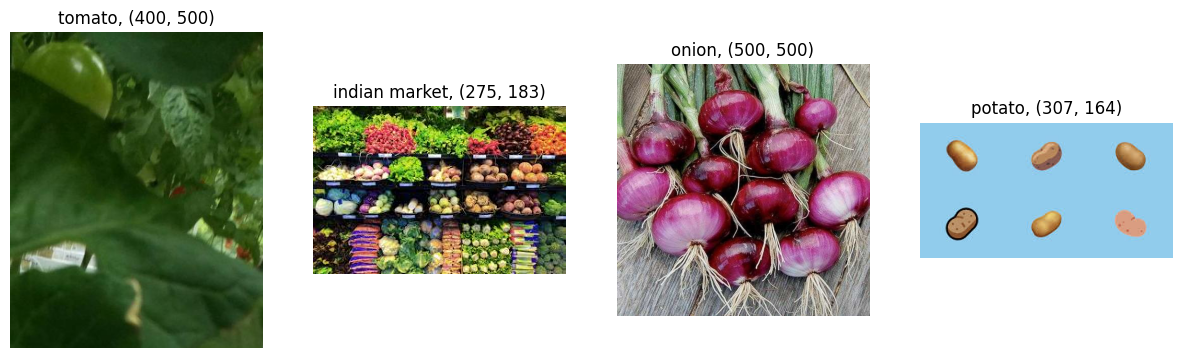

In [9]:
plt.figure(figsize=(15, 7))

for i, (cls, img) in enumerate(image_dict.items()):
  ax = plt.subplot(1, 4, i + 1)
  plt.imshow(img)
  plt.title(f'{cls}, {img.size}')
  plt.axis('off')

• Analyze how our Dataset consists of uneven sized images !

• We have some images of the market, which we will label as class 'noise'

• To feed this data into our models, we need to preprocess it

# Class Distribution Analysis:


*   Let's visualize how many samples of each class we have and if there's any class imbalance or not

*   Plotting our Class distributions using our image_dict and count_dict which stores the images for each class along with its count

*   We also feed our count_dict to a Dataframe to print the count for each class in our training and test directories








Count of training samples per class:
            class  count
0         tomato    789
1  indian market    599
2          onion    849
3         potato    898 



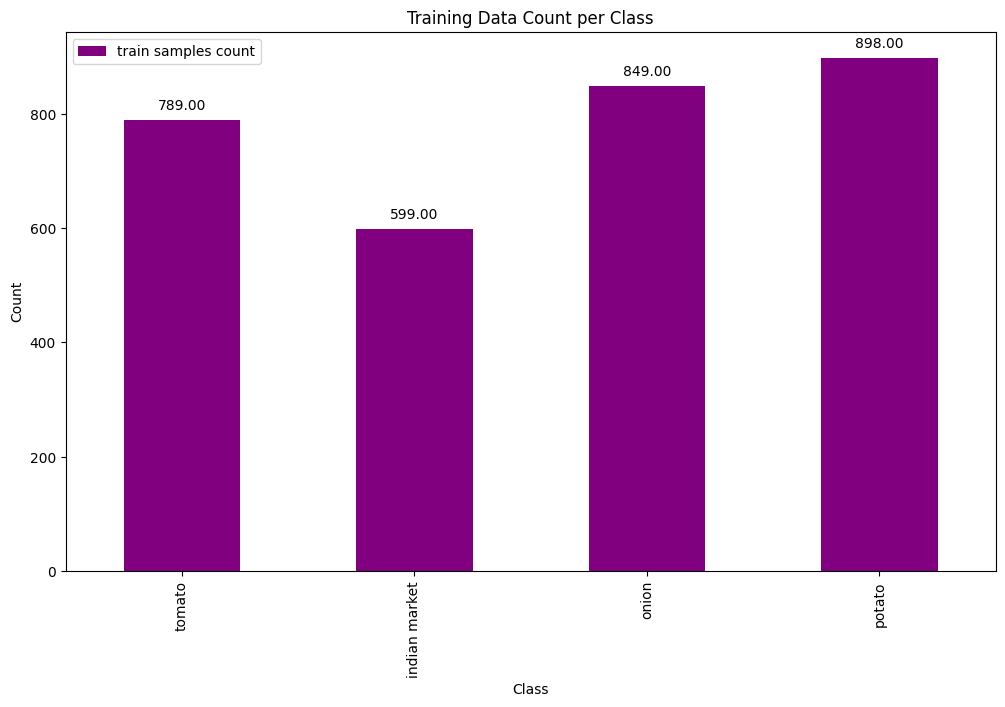

In [10]:
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),
    "count": count_dict.values()
})

print("Count of training samples per class:\n", df_count_train, "\n")

b = df_count_train.plot.bar(x='class', y='count', title="Training Data Count per Class", label="train samples count", color='purple', figsize=(12, 7))
b.set_xlabel("Class")
b.set_ylabel("Count")

for q in b.patches:
    b.annotate(f'{q.get_height():0.2f}', (q.get_x() + q.get_width() / 2., q.get_height()),
               ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

• From the above plot, we can quickly analyze that our Data is not evenly distributed, but is also not imbalanced, so we are good to go !

• But what about the minority class (indian market) ?

  • We will use some (techniques) before feeding images to our network so that our model is generalized and is not biased for any
  class !

Count of test samples per class:
            class  count
0         tomato    106
1  indian market     81
2          onion     83
3         potato     81 



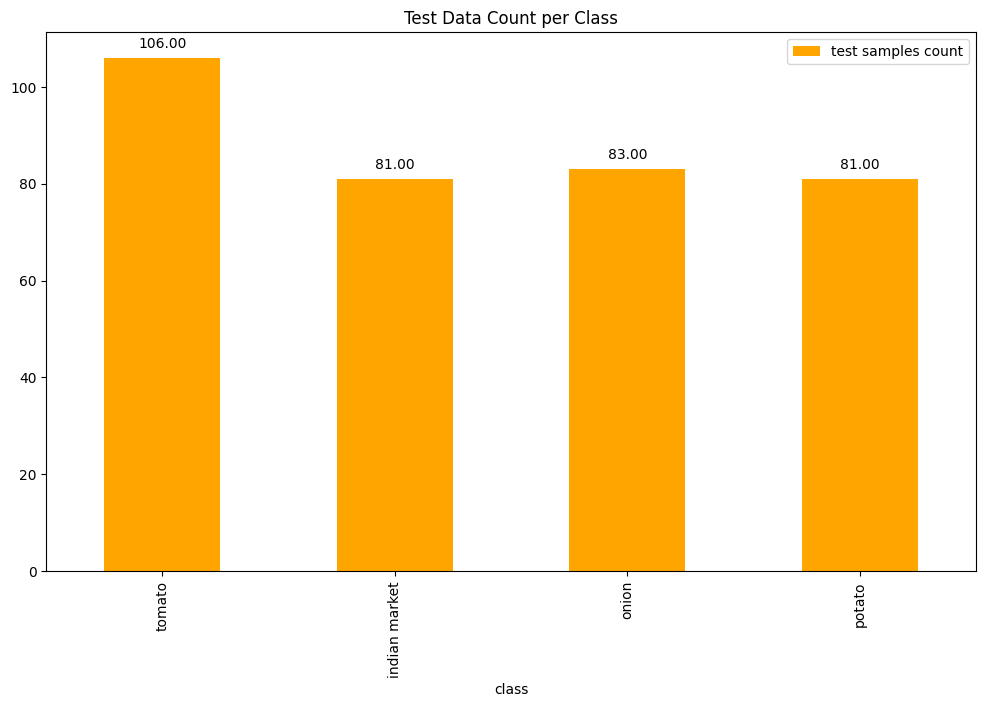

In [11]:
df_count_test = pd.DataFrame({
    "class": count_dict_test.keys(),
    "count": count_dict_test.values()
})

print("Count of test samples per class:\n", df_count_test, "\n")

a = df_count_test.plot.bar(x='class', y='count', title="Test Data Count per Class", label="test samples count", color='orange', figsize=(12, 7))
b.set_xlabel("Class")
b.set_ylabel("Count")

for p in a.patches:
  a.annotate(f'{p.get_height():0.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
             ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

• From the above plot, we can quickly analyze that our Data is not evenly distributed, but is also not imbalanced, so we are good to go !

• But what about the minority class (indian market) ?

• We will use some {techniques) before feeding images to our network so that our model is generalized and is not biased for any
class !

#  Mounting the Dataset
Now that we have analyzed and Explored our Raw Data, now to feed our Data into our model,

• Every image needs to be labelled according to its class and converted to a tensor.

• We will split our data into 3 sets: Train, Test and Validation

For this task, we will use tf.keras.utils.image_dataset_from_directory, which will :

• Create an (image, label) pair for everylimage

• Automatically label the images using one-hot encoding

• Eg: An image in the folder indian market will be labelled as [1, 0, 0, 0]

• Since we have 4 classes, our classes will be one-hot encoded alphabetically,

• meaning our first class is indian market, fourth will be tomato.

• Batching (Grouping) images together according to batch_size

• Resize the Images to the shape (256, 256)

• Seed the shuffling of our images, so that it shuffles in a 'fixed way

• which will be used to create our validation data

• Splitting 20% of our training data for validation

• Shuffling the data according to the seed

In [12]:
train_dir = '/content/ninjacart_data/train'
test_dir = '/content/ninjacart_data/test'

In [13]:
image_size = (256, 256)

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory = train_dir,
                                                       label_mode = 'categorical',
                                                       batch_size = 32,
                                                       image_size = image_size,
                                                       seed = 2022,
                                                       validation_split = 0.2,
                                                       subset = 'training',
                                                       shuffle = True)

Found 3135 files belonging to 4 classes.
Using 2508 files for training.


In [15]:
test_ds = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                      label_mode = 'categorical',
                                                      batch_size = 32,
                                                      image_size = image_size,
                                                      seed = 2022)

Found 351 files belonging to 4 classes.


specifying our Validation data, which we took from our train_ds specifying validation_split = 0.2

We take the last 20% data from our train_ds, we use the same seed as train_ds

In [16]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=image_size,
    seed=2022,
    validation_split=0.2,
    subset='validation',
    shuffle=True
)


Found 3135 files belonging to 4 classes.
Using 627 files for validation.


Since label_mode = 'categorical' one-hot encodes the classes alphabetically, 'indian market' (which we consider noise) will be class 0 and 'tomato' will be class 3.

In [17]:
class_names = [ 'noise', 'onion' , 'potato', 'tomato' ]

# Building custom CNN model
Let's build a baseline CNN Architecture with some Convolutional blocks which MaxPooling,

# **Defining the model architecture**

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Compiling the Model

In [19]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', 'Precision', 'Recall'])

# Model Training

• Implementing TensorBoard callback to plot our model's metrics later and store them in our log directory

In [20]:
log_dir_1 = "logs/Custom_CNN_overfit"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = log_dir_1, histogram_freq = 1)

In [23]:
history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=[tensorboard_cb])

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 637s 8s/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2848 - loss: 1.3677 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3668 - val_loss: 1.3000
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 675s 8s/step - Precision: 0.2930 - Recall: 0.0065 - accuracy: 0.3996 - loss: 1.2586 - val_Precision: 0.9038 - val_Recall: 0.0750 - val_accuracy: 0.5997 - val_loss: 1.1009
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 686s 8s/step - Precision: 0.7957 - Recall: 0.1889 - accuracy: 0.5656 - loss: 1.0277 - val_Precision: 0.7616 - val_Recall: 0.3413 - val_accuracy: 0.6156 - val_loss: 0.9393
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 680s 8s/step - Precision: 0.8288 - Recall: 0.3809 - accuracy: 0.6637 - loss: 0.8838 - val_Precision: 0.7985 - val_Recall: 0.5247 - val_accuracy: 0.6826 - val_loss: 0.8299
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 682s 8s/step - Precision: 0.7979 - Recall: 0.5443 - accuracy: 0.6960 - loss: 0.7892 - val_Precision: 0.8234 - 

# Plotting our Model's perfomance

In [24]:
import matplotlib.pyplot as plt

def plot_acc_loss(model_history, n_epochs):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax = axes.ravel()

    # Correcting the x-axis range
    epochs = range(1, n_epochs + 1)

    # Plotting accuracy
    ax[0].plot(epochs, [acc * 100 for acc in model_history.history['accuracy']], label='Train', color='b')
    ax[0].plot(epochs, [acc * 100 for acc in model_history.history['val_accuracy']], label='Val', color='r')
    ax[0].set_title('Accuracy vs epochs', fontsize=15)
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Accuracy (%)', fontsize=15)
    ax[0].legend()

    # Plotting loss
    ax[1].plot(epochs, model_history.history['loss'], label='Train', color='b')
    ax[1].plot(epochs, model_history.history['val_loss'], label='Val', color='r')
    ax[1].set_title('Loss vs epochs', fontsize=15)
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('Loss', fontsize=15)
    ax[1].legend()

    plt.show()

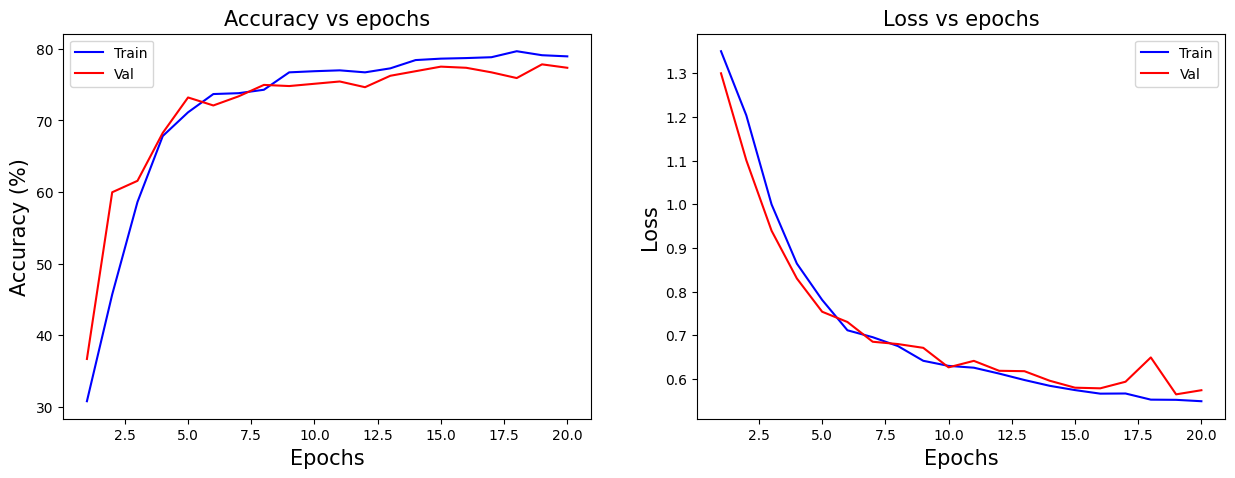

In [25]:
plot_acc_loss(history, n_epochs = 20)

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 114,062 (445.56 KB)

 Trainable params: 38,020 (148.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,042 (297.04 KB)

# Testing the model
 List all the files in our test directory and append their complete paths to a list test images which we will use to test our model by predicting n on random unseen data.

In [27]:
test_images = []

for folder in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, folder)):
    test_images.append(os.path.join(test_dir, folder, image))

# Random Sample testing

test our model on a random sample:

• Read a random image from test images list containing paths of all test images

• Resize an image to (256, 256)

• Add an extra dimension to our image's first dimension index

• Predict on the image using model.predict()

In [28]:
def grid_test_model(model_name):

  fig = plt.figure(1, figsize=(17, 11))
  plt.axis('off')
  n = 0
  for i in range(8):
    n += 1

    img_0 = tf.keras.utils.load_img(random.choice(test_images))
    img_0 = tf.keras.utils.img_to_array(img_0)
    img_0 = tf.image.resize(img_0, (256, 256))
    img_1 = tf.expand_dims(img_0, axis = 0)

    pred = model_name.predict(img_1)
    predicted_label = tf.argmax(pred, 1).numpy().item()

    for item in pred :
      item = tf.round((item*100))

    plt.subplot(2, 4, n)
    plt.axis('off')
    plt.title(f'prediction : {class_names[predicted_label]}\n\n'
              f'{item[0]} % {class_names[0]}\n'
              f'{item[1]} % {class_names[1]}\n'
              f'{item[2]} % {class_names[2]}\n'
              f'{item[3]} % {class_names[3]}')
    plt.imshow(img_0/255)
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


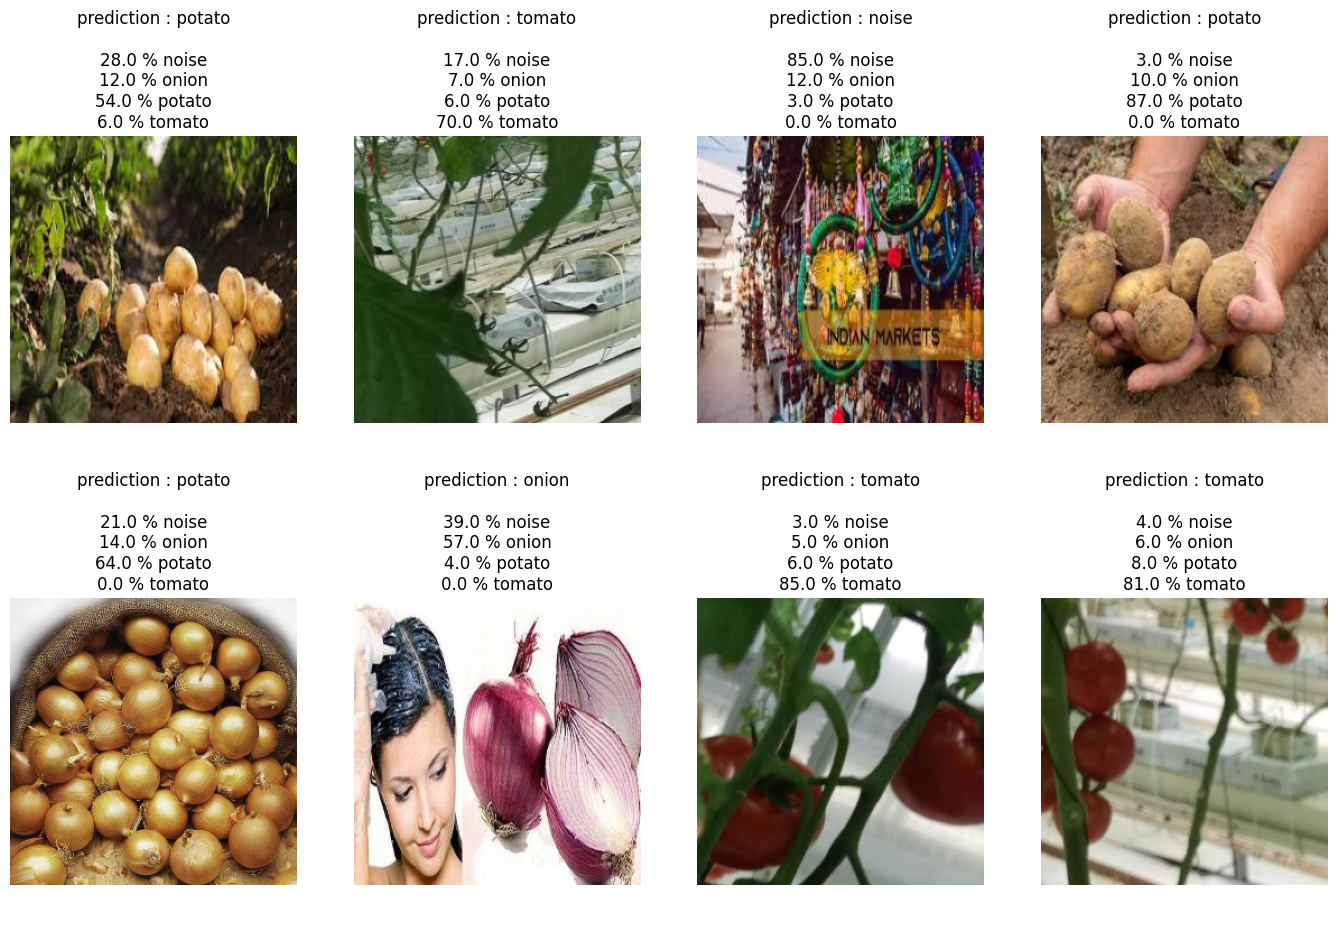

In [29]:
grid_test_model(model)

Observing the above plot, we can analyze that our model is not confident about the correct class.

 To improve this, we need to revamp our model to increase its confidence.
 Also, notice how our images are evenly sized (256x256) now!

# Evaluating accuracy on each class:
 1. First, we specify the paths for each of our test classes.
 2. We define a function `classwise_accuracy`, which calculates accuracy for each class
    by taking the class path and model as input.
 3. Inside the function:
    - We append all the file paths for the input class into a list.
    - Predict on all images and check if the label and predicted label match.
    - Calculate the accuracy of our model for the given class based on correct predictions.

In [30]:
noise_path = '/content/ninjacart_data/test/indian market'
onion_path = '/content/ninjacart_data/test/onion'
potato_path = '/content/ninjacart_data/test/potato'
tomato_path = '/content/ninjacart_data/test/tomato'

In [31]:
def classwise_accuracy(class_path, class_name, model_name):
    paths = [os.path.join(class_path, i) for i in os.listdir(class_path)]
    correct = 0
    total = len(paths)

    for img_path in paths:
        img = tf.keras.utils.load_img(img_path)
        img = tf.keras.utils.img_to_array(img)
        img = tf.image.resize(img, (256, 256))
        img = tf.expand_dims(img, axis=0)

        pred = model_name.predict(img)
        if tf.argmax(pred[0]) == class_names.index(class_name):
            correct += 1

    accuracy = (correct / total) * 100
    print(f"Accuracy for class {class_name}: {accuracy:.2f}% ({total} images)")

In [32]:
classwise_accuracy(noise_path, 'noise', model)
classwise_accuracy(onion_path, 'onion', model)
classwise_accuracy(potato_path, 'potato', model)
classwise_accuracy(tomato_path, 'noise', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━

# Plotting the Confusion Matrix:
• We define four empty lists, in which we will store predicted classes by our model for a particular class images
- We define a function conf mat which takes in the path of the class, empty list and the model
• The function reads an image from the given path, resizes it and converts to RGB
* Add an extra dimension at first index of the image and predict on the image with the input model
* Check which class the model has predicted the image belongs to and

*  append +1 to the index of the class

Eg: If the model predicts that the image belangs to class tomato

 we will append +1 at the fourth index(3) of our list like [0, 0, 0, 1]

• After calculating the value in our 4 lists for each class.
we combine them, which gives us the confusion matrix of our model and plot them with seabor

In [33]:
noise, tomato, potato, onion = 0, 0, 0, 0

l1 = []
l2 = []
l3 = []
l4 = []

In [34]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set(font_scale=1.2)

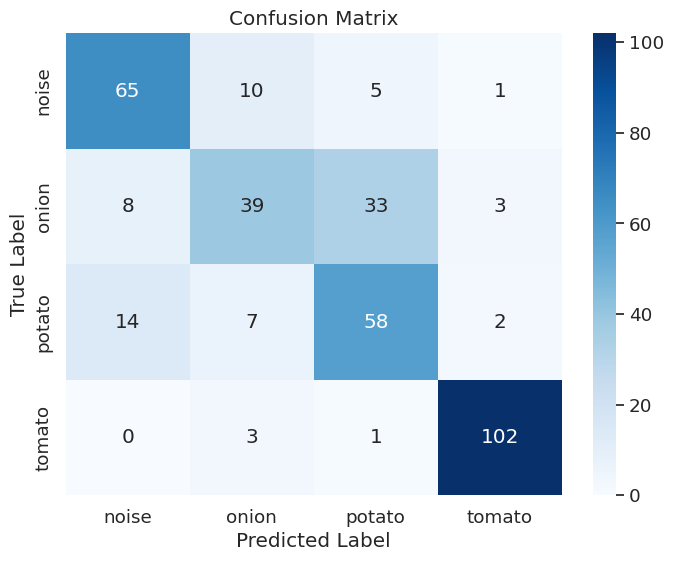

In [35]:
def conf_mat(path, noise_list, onion_list, potato_list, tomato_list, model_name):
    """
    Function to compute predicted classes for images in a given path
    and append them to the appropriate list based on the true class.
    """
    for i in os.listdir(path):
        # Load and preprocess the image
        img = tf.keras.utils.load_img(path + '/' + str(i))
        img = tf.keras.utils.img_to_array(img)
        img = tf.image.resize(img, (256, 256))
        img = tf.expand_dims(img, axis=0)  # Add batch dimension

        # Predict the class of the image
        pred = model_name.predict(img, verbose=0)
        predicted_class = tf.argmax(pred[0]).numpy()

        # Append the prediction to the corresponding list
        if path == noise_path:
            noise_list.append(predicted_class)
        elif path == onion_path:
            onion_list.append(predicted_class)
        elif path == potato_path:
            potato_list.append(predicted_class)
        elif path == tomato_path:
            tomato_list.append(predicted_class)

# Call the function for each class path
conf_mat(noise_path, l1, l2, l3, l4, model)
conf_mat(onion_path, l1, l2, l3, l4, model)
conf_mat(potato_path, l1, l2, l3, l4, model)
conf_mat(tomato_path, l1, l2, l3, l4, model)

# Combine the lists into a confusion matrix
confusion_matrix = [
    [l1.count(0), l1.count(1), l1.count(2), l1.count(3)],
    [l2.count(0), l2.count(1), l2.count(2), l2.count(3)],
    [l3.count(0), l3.count(1), l3.count(2), l3.count(3)],
    [l4.count(0), l4.count(1), l4.count(2), l4.count(3)]
]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

 **Model Tuning - Solving Overfitting**

 Augmenting Our Data:
 Data Augmentation introduces our model to different aspects and visualizations of class images,
 therefore increasing model generalization.

 We apply 3 types of augmentation on our training dataset:

 1. RandomFlip: Randomly flips images horizontally and vertically during training
 2. RandomRotation: Randomly rotates images during training by a specified factor
 3. RandomTranslation: Randomly translates images during training by a shift

In [36]:

import tensorflow as tf

# Data augmentation layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2)
])

# Apply data augmentation to the training dataset
aug_ds = train_ds

for image, label in aug_ds :
  image = data_augmentation(image)

# **Adding BatchNormalization and Dropout to improve generalization**

 Dropout and BatchNormalization are added to the model architecture to help improve generalization.

 How do they help?

 1. Dropout(): Drops out random neurons during training, forcing the model to focus on every feature for prediction.
 2. BatchNormalization(): Normalizes the inputs from the previous layer for every mini-batch before sending it to the next layer.
   It helps maintain the distribution of the data by making it a normal distribution (mean = 0, std = 1).


In [37]:
model_revamp = tf.keras.Sequential([

    tf.keras.layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),  # Corrected input_shape placement

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(4, activation='softmax')

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
model_revamp.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', 'Precision', 'Recall'])

# Implementing Callbacks
	•	TensorBoard: Enables visualizations for TensorBoard to monitor our model’s metrics, which can be plotted later for analysis.

	•	ModelCheckpoint: Saves the model weights at a given frequency. By default, it saves the best model that has the lowest validation loss (val_loss).
  
	•	EarlyStopping: Stops training when a monitored metric (e.g., val_loss) stops improving. Includes a patience parameter (e.g., 5 epochs), which specifies how long to wait before stopping training.

In [39]:
log_dir_2 = "log/Custom_CNN_revamp"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = log_dir_2, histogram_freq = 1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN_best.keras", save_best_only = True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# Training our tuned model

In [ ]:
history_0 = model_revamp.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1139s 14s/step - Precision: 0.8317 - Recall: 0.5068 - accuracy: 0.6670 - loss: 0.8121 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2408 - val_loss: 1.4028
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1160s 14s/step - Precision: 0.8592 - Recall: 0.7453 - accuracy: 0.8079 - loss: 0.5300 - val_Precision: 0.3404 - val_Recall: 0.2297 - val_accuracy: 0.2297 - val_loss: 1.5652
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1178s 15s/step - Precision: 0.8596 - Recall: 0.7715 - accuracy: 0.8144 - loss: 0.4682 - val_Precision: 0.2315 - val_Recall: 0.2297 - val_accuracy: 0.2313 - val_loss: 1.8906
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1164s 15s/step - Precision: 0.8841 - Recall: 0.8050 - accuracy: 0.8490 - loss: 0.4133 - val_Precision: 0.2594 - val_Recall: 0.2313 - val_accuracy: 0.2392 - val_loss: 1.9308
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1143s 14s/step - Precision: 0.8851 - Recall: 0.8234 - accuracy: 0.8547 - loss: 0.3642 - val_Precision: 0.3631 

In [ ]:
result = model_revamp.evaluate(test_ds)
dict(zip(model_revamp.metrics_names, result))

**We observe an accuracy jump of ~10 % by just :**

• Applying augmentation to our data

• Adding Dropout and BatchNormalization

• Implementing callbacks during training

In [ ]:
l1 = []
l2 = []
l3 = []
l4 = []

conf_mat(noise_path, l1, model_revamp)
conf_mat(onion_path, l2, model_revamp)
conf_mat(potato_path, l3, model_revamp)
conf_mat(tomato_path, l4, model_revamp)

ax = sns.heatmap([l1, l2, l3, l4], xticklabels = class_names, yticklabels = class_names, annot=True, fmt="d", cmap="Blues")
ax.set(xlabel='Predicted Label', ylabel='True Label', title='Confusion Matrix')
plt.show()

**From the Confusion matrix plotted above, we can observe that :**

* Our model can easily differentiate between all classes with minimal error
* Potato and onion are the most confusing classes for our model
* Tomato can be easily differentiated with the smallest error

In [ ]:
plot_acc_loss(history_0, n_epochs = 14)

In [ ]:
classwise_accuracy(noise_path, 'noise', model_revamp)
classwise_accuracy(onion_path, 'onion', model_revamp)
classwise_accuracy(potato_path, 'potato', model_revamp)
classwise_accuracy(tomato_path, 'noise', model_revamp)

# Applying Transfer Learning:

- Now that we solved the overfitting problem of our Baseline model,
- Let's also explore and implement some state-of-the-art model architectures which can give us even higher precision and accuracy.
- We explored some of the available pretrained models which we can fine-tune to our data in [Keras Docs](https://keras.io).
  We will train 3 of the most efficient and accurate pretrained models on the ImageNet dataset.

The Models we will use:
- **VGG-19**
- **ResNet**
- **MobileNet**

---

# VGG-19

#### VGG-19 performance on ImageNet Dataset:
Let's find out how it performs on our Data after fine-tuning!

| Model   | Size (MB) | Top-1 Acc | Top-5 Acc | Parameters | Depth | Time (ms) on CPU | Time (ms) on GPU |
|---------|-----------|-----------|-----------|------------|-------|------------------|------------------|
| VGG-19  | 549       | 71.3%     | 90.0%     | 143.7M     | 19    | 84.8             | 4.4              |


In [ ]:
base_model_3 = tf.keras.applications.VGG19(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

In [ ]:
model_3 = base_model_3.output

model_3 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescaling layer
    tf.keras.layers.InputLayer(input_shape=[image_size[0], image_size[1], 3]),  # Input layer
    base_model_3,  # Another base model (if needed)
    tf.keras.layers.GlobalAveragePooling2D(),  # Global average pooling
    tf.keras.layers.Dropout(0.1),  # Dropout layer with a 50% drop rate (you can adjust this)
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer with 4 classes
])

In [ ]:
model_3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
log_dir_5 = "logs/VGG19_fine_tuned"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = log_dir_5, histogram_freq = 1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("VGG19_best.keras", save_best_only = True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
history_3 = model_3.fit(aug_ds, epochs=50, validation_data=valid_ds, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

# Evaluating VGG-19

In [ ]:
plot_acc_loss(history_3, n_epochs = 14)

In [ ]:
classwise_accuracy(noise_path, 'noise', model_3)
classwise_accuracy(onion_path, 'onion', model_3)
classwise_accuracy(potato_path, 'potato', model_3)
classwise_accuracy(tomato_path, 'noise', model_3)

In [ ]:
l1 = []
l2 = []
l3 = []
l4 = []

conf_mat(noise_path, l1, model_3)
conf_mat(onion_path, l2, model_3)
conf_mat(potato_path, l3, model_3)
conf_mat(tomato_path, l4, model_3)

ax = sns.heatmap([l1, l2, l3, l4], xticklabels = class_names, yticklabels = class_names, annot=True, fmt="d", cmap="Blues")
ax.set(xlabel='Predicted Label', ylabel='True Label', title='Confusion Matrix')
plt.show()

In [ ]:
result = model_3.evaluate(test_ds)
dict(zip(model_3.metrics_names, result))

<h1>Models Comparison</h1>

<h2>ResNet50 Performance on ImageNet Dataset:</h2>

<table style="border-collapse: collapse; width: 100%; text-align: left;">
  <tr style="border: 1px solid black;">
    <th style="border: 1px solid black; padding: 8px;">Metric</th>
    <th style="border: 1px solid black; padding: 8px;">Value</th>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black; padding: 8px;">Size (MB)</td>
    <td style="border: 1px solid black; padding: 8px;">98</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black; padding: 8px;">Top-1 Accuracy</td>
    <td style="border: 1px solid black; padding: 8px;">74.9%</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black; padding: 8px;">Top-5 Accuracy</td>
    <td style="border: 1px solid black; padding: 8px;">92.1%</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black; padding: 8px;">Parameters</td>
    <td style="border: 1px solid black; padding: 8px;">25.6M</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black; padding: 8px;">Depth</td>
    <td style="border: 1px solid black; padding: 8px;">107</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black; padding: 8px;">Time (ms) on CPU</td>
    <td style="border: 1px solid black; padding: 8px;">58.2</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black; padding: 8px;">Time (ms) on GPU</td>
    <td style="border: 1px solid black; padding: 8px;">4.6</td>
  </tr>
</table>

<h2>Conclusion:</h2>
<p>Now that we have reviewed the performance of ResNet50 on the ImageNet dataset, let's explore how it performs on our specific data.</p>

In [ ]:
base_model_1 = base_model.output

model_1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescaling layer
    tf.keras.layers.InputLayer(input_shape=[image_size[0], image_size[1], 3]),  # Input layer
    base_model_1,  # Another base model (if needed)
    tf.keras.layers.GlobalAveragePooling2D(),  # Global average pooling
    tf.keras.layers.Dropout(rate = 0.1),
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer with 4 classes
])

In [ ]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
log_dir_3 = "logs/ResNet"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = log_dir_3, histogram_freq = 1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ResNet_best.keras", save_best_only = True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
history_1 = model_1.fit(aug_ds, epochs=50, validation_data=valid_ds, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

# Evaluating ResNet

In [ ]:
plot_acc_loss(history_1, epochs = 20)

In [ ]:
classwise_accuracy(noise_path, 'noise', model_1)
classwise_accuracy(onion_path, 'onion', model_1)
classwise_accuracy(potato_path, 'potato', model_1)
classwise_accuracy(tomato_path, 'noise', model_1)

In [ ]:
l1 = []
l2 = []
l3 = []
l4 = []

conf_mat(noise_path, l1, model_1)
conf_mat(onion_path, l2, model_1)
conf_mat(potato_path, l3, model_1)
conf_mat(tomato_path, l4, model_1)

ax = sns.heatmap([l1, l2, l3, l4], xticklabels = class_names, yticklabels = class_names, annot=True, fmt="d", cmap="Blues")
ax.set(xlabel='Predicted Label', ylabel='True Label', title='Confusion Matrix')
plt.show()

In [ ]:
result = model_1.evaluate(test_ds)
dict(zip(model_1.metrics_names, result))

We achieved a test accuracy of 94% on our fine-tuned ResNet model. Now, let’s fine-tune a smaller-sized model to deploy on our mobile app.

### MobileNet Model

#### MobileNet performance on ImageNet Dataset:
Let's find out how it performs on our Data!

| Model      | Size (MB) | Top-1 Acc | Top-5 Acc | Parameters | Depth | Time (ms) on CPU | Time (ms) on GPU |
|------------|-----------|-----------|-----------|------------|-------|------------------|------------------|
| MobileNet  | 16        | 70.4%     | 89.5%     | 4.3M       | 5     | 22.6             | 3.4              |


In [ ]:
base_model_2 = tf.keras.applications.MobileNet(input_shape=(256, 256, 3), include_top=False)

In [ ]:
model_2 = base_model_2.output

model_2 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescaling layer
    tf.keras.layers.InputLayer(input_shape=[image_size[0], image_size[1], 3]),  # Input layer
    base_model_2,  # Another base model (if needed)
    tf.keras.layers.GlobalAveragePooling2D(),  # Global average pooling
    tf.keras.layers.Dropout(rate = 0.1),
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer with 4 classes
])

In [ ]:
log_dir_4 = "logs/MobileNet"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = log_dir_4, histogram_freq = 1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("MobileNet_best.keras", save_best_only = True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
history_2 = model_2.fit(aug_ds, epochs=50, validation_data=valid_ds, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

# Evaluating MobileNet

In [ ]:
plot_acc_loss(history_2, n_epochs = 20)

In [ ]:
classwise_accuracy(noise_path, 'noise', model_2)
classwise_accuracy(onion_path, 'onion', model_2)
classwise_accuracy(potato_path, 'potato', model_2)
classwise_accuracy(tomato_path, 'noise', model_2)

In [ ]:
l1 = []
l2 = []
l3 = []
l4 = []

conf_mat(noise_path, l1, model_2)
conf_mat(onion_path, l2, model_2)
conf_mat(potato_path, l3, model_2)
conf_mat(tomato_path, l4, model_2)

ax = sns.heatmap([l1, l2, l3, l4], xticklabels = class_names, yticklabels = class_names, annot=True, fmt="d", cmap="Blues")
ax.set(xlabel='Predicted Label', ylabel='True Label', title='Confusion Matrix')
plt.show()

In [ ]:
result = model_2.evaluate(test_ds)
dict(zip(model_2.metrics_names, result))

### Models Comparison

#### Summary of Trained Models:

| Model         | Test Acc | Train Acc |
|---------------|----------|-----------|
| Custom CNN    | 76%      | 81%       |
| CNN Revamp    | 84%      | 89%       |
| VGG19         | 91%      | 98%       |
| ResNet50      | 94%      | 99%       |
| MobileNet     | 90%      | 100%      |

---

- After training all of our models, we found **VGG19** to be the most accurate model on our Dataset.
- Let's visualize all of our models via **TensorBoard** from the logs we created during training.
- We observed that **VGG-19** gave us the highest test accuracy, and our baseline **Custom CNN** gave us the lowest accuracy.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs

# **Testing Our Best Model (ResNet)**

*	ResNet achieved the highest accuracy of 94% among all the models we trained.
*	Let’s test our Fine-Tuned ResNet on some random unseen data to visualize how accurate it is in making predictions.




In [ ]:
model_1.summary()

In [ ]:
grid_test_model(model_1)

In [ ]:
result = model_1.evaluate(test_ds)
dict(zip(model_1.metrics_names, result))